# MRMR with Feature-engine

In this notebook, we'll completely automate the search of features using the MRMR framework with the open source Python library Feature-engine. 

In [1]:
from itertools import compress

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

from feature_engine.selection import MRMR

In [2]:
# load dataset

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
y = y.map({0:1, 1:0})

X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

## F-statistic and correlation

We'll start by using the F-statistic and correlation as measures of relevance and redundancy, obtaining the ration between the 2.

In [4]:
# we'll select 10 features

sel = MRMR(method="FCQ", max_features=10, regression=False)

sel.fit(X, y)

MRMR(max_features=10, method='FCQ')

In [5]:
# the F statistic

sel.relevance_

array([6.46981021e+02, 1.18096059e+02, 6.97235272e+02, 5.73060747e+02,
       8.36511234e+01, 3.13233079e+02, 5.33793126e+02, 8.61676020e+02,
       6.95274435e+01, 9.34592949e-02, 2.68840327e+02, 3.90947023e-02,
       2.53897392e+02, 2.43651586e+02, 2.55796780e+00, 5.32473391e+01,
       3.90144816e+01, 1.13262760e+02, 2.41174067e-02, 3.46827476e+00,
       8.60781707e+02, 1.49596905e+02, 8.97944219e+02, 6.61600206e+02,
       1.22472880e+02, 3.04341063e+02, 4.36691939e+02, 9.64385393e+02,
       1.18860232e+02, 6.64439606e+01])

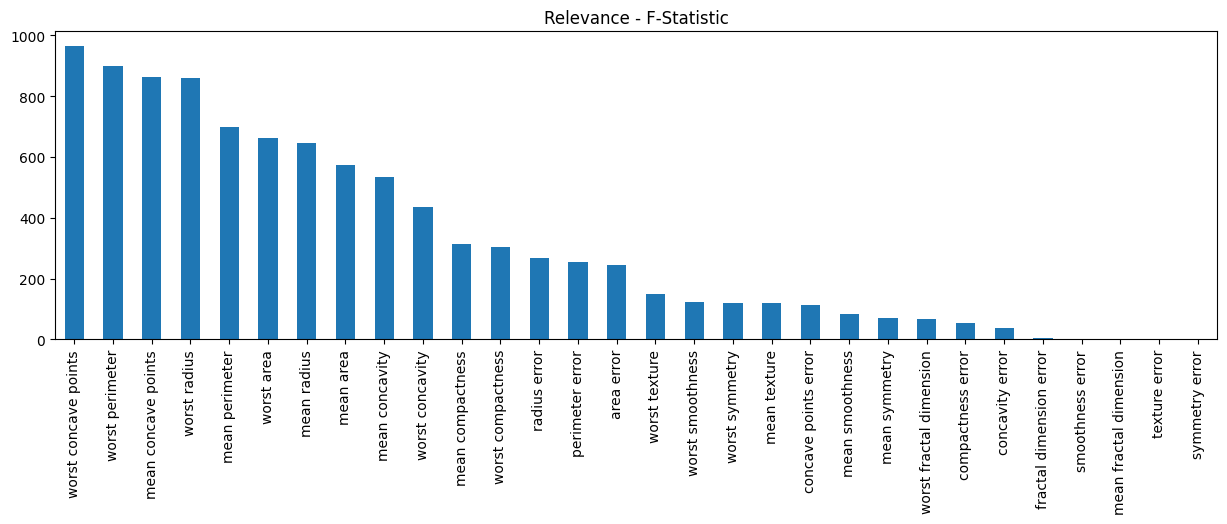

In [6]:
pd.Series(sel.relevance_, index=sel.variables_).sort_values(
    ascending=False).plot.bar(figsize=(15, 4))
plt.title("Relevance - F-Statistic")
plt.show()

In [7]:
# the list of selected features

list(compress(sel.variables_, sel.get_support()))

['mean radius',
 'mean perimeter',
 'mean area',
 'mean concavity',
 'mean concave points',
 'worst radius',
 'worst perimeter',
 'worst area',
 'worst concavity',
 'worst concave points']

In [8]:
# the list of features that will be removed

sel.features_to_drop_

['mean texture',
 'mean smoothness',
 'mean compactness',
 'mean symmetry',
 'mean fractal dimension',
 'radius error',
 'texture error',
 'perimeter error',
 'area error',
 'smoothness error',
 'compactness error',
 'concavity error',
 'concave points error',
 'symmetry error',
 'fractal dimension error',
 'worst texture',
 'worst smoothness',
 'worst compactness',
 'worst symmetry',
 'worst fractal dimension']

In [9]:
# remove features from the dataframe

Xtr = sel.transform(X_test)

print(Xtr.head())

     mean radius  mean perimeter  mean area  mean concavity  \
512        13.40           88.64      556.7         0.14450   
457        13.21           84.10      537.9         0.02772   
439        14.02           89.59      606.5         0.02087   
298        14.26           91.22      633.1         0.02475   
37         13.03           82.61      523.8         0.02562   

     mean concave points  worst radius  worst perimeter  worst area  \
512              0.08172         16.41           113.30       844.4   
457              0.02068         14.35            91.29       632.9   
439              0.02652         14.91            96.53       688.9   
298              0.01374         16.22           105.80       819.7   
37               0.02923         13.30            84.46       545.9   

     worst concavity  worst concave points  
512          0.51060               0.20510  
457          0.13900               0.06005  
439          0.06260               0.08216  
298          0

## Random forest

Now, we'll use the importance derived from random forests as relevance, correlation as redundancy and the ratio between the 2 to select features.

In [10]:
# feature engine optimizes the random forest with CV

sel = MRMR(
    method="RFCQ",
    scoring="roc_auc",
    param_grid = {"n_estimators": [5, 50, 500], "max_depth":[1,2,3]},
    cv=3,
    regression=False,
    random_state=42,
)

sel.fit(X, y)

MRMR(method='RFCQ',
     param_grid={'max_depth': [1, 2, 3], 'n_estimators': [5, 50, 500]},
     random_state=42)

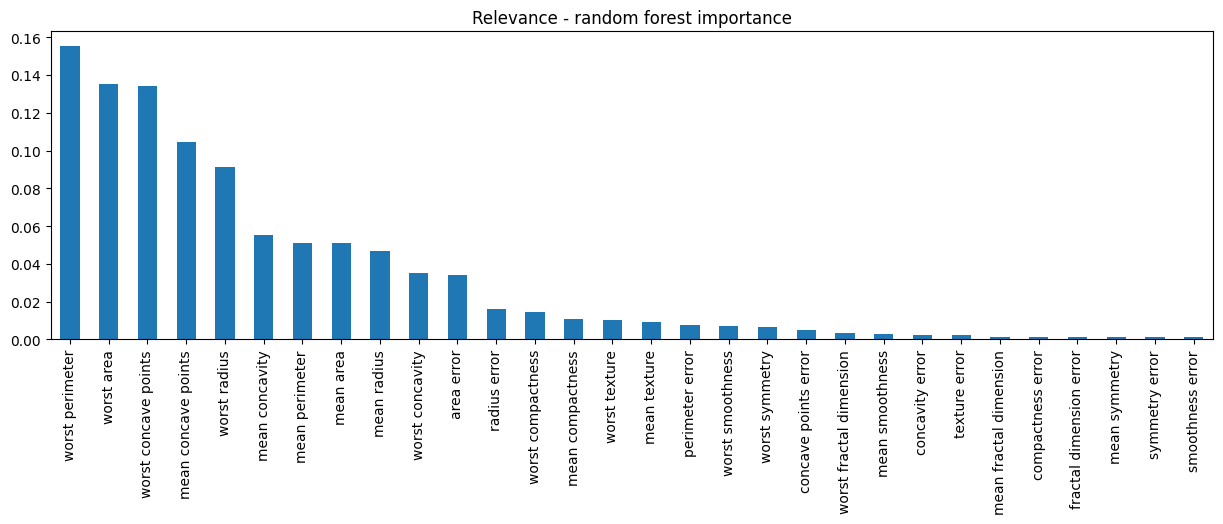

In [11]:
# the feature importance obtained from the random forest

pd.Series(sel.relevance_, index=sel.variables_).sort_values(
    ascending=False).plot.bar(figsize=(15, 4))
plt.title("Relevance - random forest importance")
plt.show()

In [12]:
# the list of selected features

list(compress(sel.variables_, sel.get_support()))

['mean concave points',
 'fractal dimension error',
 'worst radius',
 'worst perimeter',
 'worst area',
 'worst concave points']

In [13]:
# remove features from the dataframe

Xtr = sel.transform(X_test)

Xtr.head()

,mean concave points,fractal dimension error,worst radius,worst perimeter,worst area,worst concave points
512,0.08172,0.004005,16.41,113.30,844.4,0.20510
457,0.02068,0.001828,14.35,91.29,632.9,0.06005
439,0.02652,0.002104,14.91,96.53,688.9,0.08216
298,0.01374,0.001957,16.22,105.80,819.7,0.07530
37,0.02923,0.001777,13.30,84.46,545.9,0.05013


## mutual information

Finally, we'll use the mutual information as measure of relevance and importance.

In [14]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X[['AveRooms', 'AveBedrms', 'AveOccup']] = X[['AveRooms', 'AveBedrms', 'AveOccup']].astype(int)

print(X.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0         6          1       322.0         2     37.88   
1  8.3014      21.0         6          0      2401.0         2     37.86   
2  7.2574      52.0         8          1       496.0         2     37.85   
3  5.6431      52.0         5          1       558.0         2     37.85   
4  3.8462      52.0         6          1       565.0         2     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

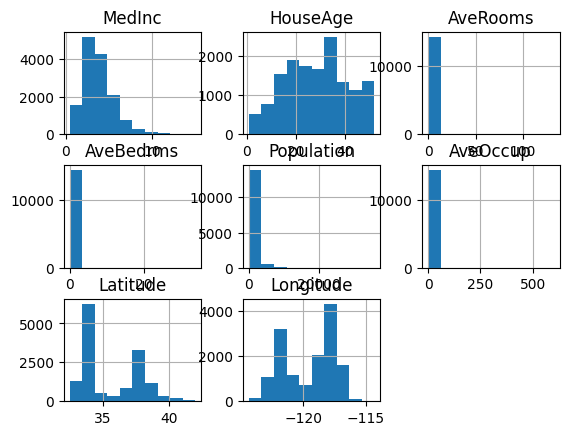

In [16]:
X_train.hist()
plt.show()

In [17]:
sel = MRMR(
    # we want to examine a subset of the variables:
    variables = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup'],
    method="MIQ",
    # some variables are discrete:
    discrete_features=[False, False, True, True, False, True],
    regression=True, 
    random_state=42,
)

sel.fit(X,y)

MRMR(discrete_features=[False, False, True, True, False, True], random_state=42,
     regression=True,
     variables=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
                'AveOccup'])

In [18]:
# now we remove the variables from the data

Xtr = sel.transform(X)

Xtr.head()

,MedInc,AveOccup,Latitude,Longitude
0,8.3252,2,37.88,-122.23
1,8.3014,2,37.86,-122.22
2,7.2574,2,37.85,-122.24
3,5.6431,2,37.85,-122.25
4,3.8462,2,37.85,-122.25


That's it! Now you know the ins and outs of how MRMR selects features, and how to apply it with a few lines of codes by using Feature-engine's transformer.